In [117]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

In [52]:
setences = []
labels= []


In [139]:
def remove_stopwords(sentence):
  stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be",
               "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does",
               "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd",
               "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd",
               "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most",
               "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out",
               "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that",
               "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd",
               "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was",
               "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which",
               "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
               "your", "yours", "yourself", "yourselves" ]
  sentence = sentence.lower()
  words = sentence.split()
  no_stop_words = [word for word in words if word not in stopwords]
  sentence = " ".join(no_stop_words)
  return sentence



In [140]:
import csv
with open('BBC News Train.csv') as file:
  reader = csv.DictReader(file)
  next(reader)
  for row in reader:
    sentence = row['Text']
    setences.append(remove_stopwords(sentence))
    labels.append(row['Category'])


In [141]:
split = int(len(setences) * TRAINING_SPLIT)

train_sentences = setences[:split]
test_sentences = setences[split:]
train_labels = labels[:split]
test_labels = labels[split:]


In [142]:
print('{} for training {} for testing'.format(len(train_sentences), len(test_sentences)))

4764 for training 1192 for testing


In [143]:
from os import truncate
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [144]:
def fit_tokenizer(train_sentences, num_words, oov_token):
  tokenizer = Tokenizer(num_words= num_words, oov_token= oov_token)
  tokenizer.fit_on_texts(train_sentences)
  return tokenizer

In [145]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
  sequences = tokenizer.texts_to_sequences(sentences)
  padded = pad_sequences(sequences, maxlen=maxlen, padding_type=padding)

In [146]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index
print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 24981 words

<OOV> token included in vocabulary


In [147]:
def sequence_and_pad(sentences, tokenizer, padding, maxlen):
  sequences = tokenizer.texts_to_sequences(sentences)
  padded_sequences  = pad_sequences(sequences, maxlen=maxlen, padding=padding)
  return padded_sequences

In [148]:
train_padded_seq = sequence_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
test_padded_seq = sequence_and_pad(test_sentences, tokenizer, PADDING, MAXLEN)

In [149]:
def tokenize_labels(all_labels, split_labels):
  label_tokenzier = Tokenizer()
  label_tokenzier.fit_on_texts(all_labels)
  label_seq = label_tokenzier.texts_to_sequences(split_labels)
  #keras' tokenizer yields values that start at 1 rather than 0.this will yeild a problem when training
  #since keras usually expects that labels to start at 0.
  label_seq_np = np.array(label_seq)-1
  return label_seq_np


In [150]:
train_label_seq = tokenize_labels(labels, train_labels)
test_label_seq = tokenize_labels(labels, test_labels)

In [151]:
print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{test_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {test_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[1]
 [1]
 [4]
 [1]
 [2]]

First 5 labels of the validation set should look like this:
[[4]
 [4]
 [1]
 [4]
 [1]]

Tokenized labels of the training set have shape: (4764, 1)

Tokenized labels of the validation set have shape: (1192, 1)



In [152]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [153]:
epochs=20
history = model.fit(train_padded_seq, train_label_seq, epochs=epochs, validation_data=(test_padded_seq, test_label_seq))

Epoch 1/20
149/149 [==============================] - 1s 4ms/step - loss: 1.5648 - accuracy: 0.4177 - val_loss: 1.4610 - val_accuracy: 0.5268
Epoch 2/20
149/149 [==============================] - 1s 4ms/step - loss: 1.2237 - accuracy: 0.7204 - val_loss: 0.9262 - val_accuracy: 0.8221
Epoch 3/20
149/149 [==============================] - 1s 5ms/step - loss: 0.7763 - accuracy: 0.8363 - val_loss: 0.5577 - val_accuracy: 0.8977
Epoch 4/20
149/149 [==============================] - 1s 7ms/step - loss: 0.5029 - accuracy: 0.8963 - val_loss: 0.3371 - val_accuracy: 0.9320
Epoch 5/20
149/149 [==============================] - 1s 3ms/step - loss: 0.3343 - accuracy: 0.9301 - val_loss: 0.2200 - val_accuracy: 0.9581
Epoch 6/20
149/149 [==============================] - 0s 3ms/step - loss: 0.2337 - accuracy: 0.9530 - val_loss: 0.1613 - val_accuracy: 0.9656
Epoch 7/20
149/149 [==============================] - 0s 3ms/step - loss: 0.1707 - accuracy: 0.9683 - val_loss: 0.1310 - val_accuracy: 0.9690
Epoch 

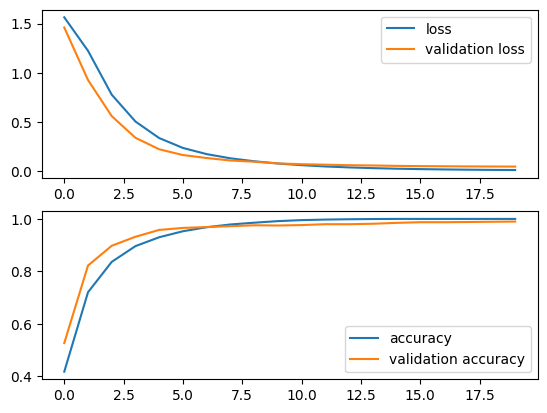

In [154]:
import matplotlib.pyplot as plt

plt, axs = plt.subplots(2)
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='validation loss')
axs[0].legend()
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='validation accuracy')
axs[1].legend()
